# Setting up the Colab Workspace


In [1]:
#Mounting the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#copying the data and unzipping
! cp '/content/drive/MyDrive/Colab Notebooks/dog-breed-identification.zip' '/content'
!unzip '/content/dog-breed-identification.zip'

Streaming output truncated to the last 5000 lines.
  inflating: train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: train/83fad0718581a696132c96c166472627.jpg  
  inflating: train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: train/8410ced9ebc1759a7ebce5c42bfb5222.jpg  
  inflating: train/84

#Data Exploration

In [3]:
import pandas as pd
import os
from shutil import copyfile

In [4]:
#reading the labels file
df=pd.read_csv('/content/labels.csv')
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [5]:
#applying jpg at the end for ease of access of image further
def apply_jpg(text):
  return text+".jpg"
df['id']=df['id'].apply(apply_jpg)

In [6]:
#counting unique breeds
print("Unique Breeds:",len(df['breed'].unique()))

Unique Breeds: 120


In [7]:
# preprocessing labels to filter only selected labels
#names of required breeds
names=['beagle', 'chihuahua', 'doberman', 'french_bulldog', 'golden_retriever',
  'malamute', 'pug', 'saint_bernard', 'scottish_deerhound', 'tibetan_mastiff']
def process_labels(text):
  if text in names:
    return text
  else:
    return 'other'

In [8]:
#applying preprocessing
df['breed']=df['breed'].apply(process_labels)

In [9]:
#checking the frequency:
df['breed'].value_counts()

other                 9381
scottish_deerhound     126
beagle                 105
pug                     94
saint_bernard           84
malamute                81
doberman                74
chihuahua               71
french_bulldog          70
tibetan_mastiff         69
golden_retriever        67
Name: breed, dtype: int64

Text(0.5, 1.0, 'Visualization of all the breeds with others')

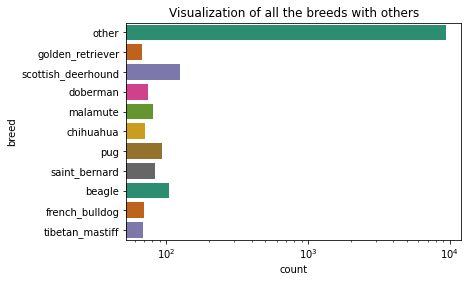

In [10]:
#vizualizing in log scale
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(y='breed', data=df,palette='Dark2',log=True)
plt.title("Visualization of all the breeds with others")

Text(0.5, 1.0, 'Visualization of all the breeds with others')

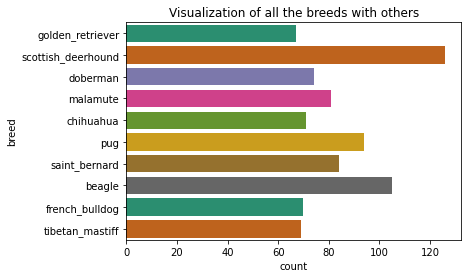

In [11]:
#vizualizing in log scale of all the selected breeds
import seaborn as sns
import matplotlib.pyplot as plt
df_new=df[df['breed']!='other']
sns.countplot(y='breed', data=df_new,palette='Dark2')
plt.title("Visualization of all the breeds with others")

In [12]:
#counting the total number of samples in the reduced dataset
df['breed'].value_counts()
sum(df['breed'].value_counts().values)-(df['breed'].value_counts().values[0])

841

# Creating the Dataset

In [13]:
#making the new directory for training dataset. 

!mkdir 'train_new'
path='/content/train_new'
for i in df['breed'].unique().tolist():
  os.mkdir(path+'/'+i) # making a new directory for every class to be predicted.

In [14]:
#copying every image from train directory to the new director as per the class
train='/content/train'
train_new='/content/train_new'
count=0
for filename in os.listdir(train):
    if filename.endswith(".jpg"): 
      sr=train+'/'+filename
      dest=train_new+'/'+(df[df['id']==filename]['breed'].values[0])+'/'+filename
      copyfile(sr,dest)
      count+=1
      continue
    else:
        continue

print(count)

10222


In [15]:
# counting the number of images from the given directories to be sure.
names=['beagle', 'chihuahua', 'doberman', 'french_bulldog', 'golden_retriever', 'malamute', 'pug', 'saint_bernard', 'scottish_deerhound', 'tibetan_mastiff']
def countname(dir,text):
  path=dir+'/'+text
  count=0
  for filename in os.listdir(path):
    if filename.endswith(".jpg"):
      count+=1
      continue
    else:
      continue
  return count


path='/content/train_new'
count=0
for name in names:
  count+=countname(path,name)
print(count)

841


In [16]:
# removing the 'other' folder
! rm -r '/content/train_new/other'

# Data Augmentation

In [17]:
# Importing required Libraries
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [18]:
# this function will plot the augmented images
def plotImages(images_arr):
    fig, axes = plt.subplots(20, 1, figsize=(30,30))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [19]:
# Setting Augmentation parameters:
gen = ImageDataGenerator(rotation_range=25, width_shift_range=0.1, height_shift_range=0.1, 
                         shear_range=0.15, zoom_range=0.1, channel_shift_range=10., 
                         horizontal_flip=True, brightness_range=(0.5, 1.6),
                         vertical_flip=True)

## Temporary Augmentation
 
Done on one image to check if parameters are satifactory or not.

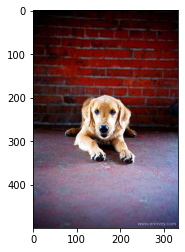

In [20]:
#visualizing a random image
path='/content/train_new/golden_retriever'
chosen_image = random.choice(os.listdir(path))
image_path = path+'/' + chosen_image
image = np.expand_dims(plt.imread(image_path),0)
plt.imshow(image[0])

In [21]:
#we'll generate batches of augmented images from the original image.
aug_iter = gen.flow(image)
#Now we'll get ten samples of the augmented images.
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(20)]

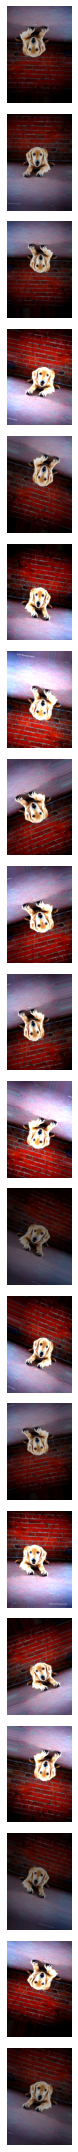

In [22]:
#Now we'll plot the augmented images.
plotImages(aug_images)

## Main Augmentation

In [23]:
#creating a directory to save augmented images
! cp -r '/content/train_new' '/content/Train_aug'

In [24]:
# Defining source and destination paths
dest_path='/content/Train_aug'
src_path='/content/train_new'
names=['beagle', 'chihuahua', 'doberman', 'french_bulldog', 'golden_retriever',
  'malamute', 'pug', 'saint_bernard', 'scottish_deerhound', 'tibetan_mastiff']

In [25]:
## creating a function for augmentation
def augmenter(name, n):
  dest=dest_path+'/'+name
  source=src_path
  i=0
  for batch in gen.flow_from_directory(
          source,  #source
          color_mode="rgb",
          target_size=(299, 299),
          batch_size=1,
          class_mode='categorical',
          classes=[name],
          save_to_dir=dest,
          save_prefix='aug',
          save_format='jpeg',
          shuffle=False,
          ):
    i += 1
    if i > n:
      break

In [26]:
title=["Breed","Present Images", "Augmented Images", "Total Images"]# setting the title for dataframe
data=[]#creating data
for i in range(len(names)):
  row=[]# creating row
  row.append(names[i])
  n=len(os.listdir(src_path+'/'+names[i]))
  row.append(n)
  # if the number of original images is greater than 83 then create total number of images of 350
  if n>83: 
    x=350

  #if the number of original images is between 83 and 70 then create total number of images of 300
  elif n<83 & n>70:
    x=300

  #if the number of original images is less than 70 then create total number of images of 200
  else:
    x=200
  
  augmenter(names[i],(x-n))
  #adding the meta data for augmentation in data list
  row.append(x-n)
  row.append(x)
  data.append(row)

Found 105 images belonging to 1 classes.
Found 71 images belonging to 1 classes.
Found 74 images belonging to 1 classes.
Found 70 images belonging to 1 classes.
Found 67 images belonging to 1 classes.
Found 81 images belonging to 1 classes.
Found 94 images belonging to 1 classes.
Found 84 images belonging to 1 classes.
Found 126 images belonging to 1 classes.
Found 69 images belonging to 1 classes.


In [27]:
# creating dataframe for metadata of augmentation
df=pd.DataFrame(data,columns=title)
df

,Breed,Present Images,Augmented Images,Total Images
0,beagle,105,245,350
1,chihuahua,71,129,200
2,doberman,74,126,200
3,french_bulldog,70,130,200
4,golden_retriever,67,133,200
5,malamute,81,119,200
6,pug,94,256,350
7,saint_bernard,84,266,350
8,scottish_deerhound,126,224,350
9,tibetan_mastiff,69,131,200


In [28]:
sum(df['Total Images'])

2600

In [29]:
# verifying the augmentation
dest_path='/content/Train_aug'
for i in names:
  print(i+" :"+str(len(os.listdir(dest_path+'/'+i))))

beagle :351
chihuahua :201
doberman :201
french_bulldog :201
golden_retriever :201
malamute :201
pug :351
saint_bernard :351
scottish_deerhound :351
tibetan_mastiff :201


# Model Building

## Preparing the data

In [30]:
# import the necessary packages
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [31]:
DIRECTORY = r"/content/Train_aug" #save the directory path
CATEGORIES = names#save the name of category

In [32]:
#preparing numpy array of images with labels
data = []
labels = []

for category in CATEGORIES: # loop through the categories
    path = os.path.join(DIRECTORY, category) #join the  directory path with the category folder

    for img in os.listdir(path): # loop through the images in one particular folder of a category.
    	img_path = os.path.join(path, img) #get the path of the image
    	image = load_img(img_path, target_size=(224, 224)) #resize the image
    	image = img_to_array(image) #convert image to numpy array

    	data.append(image) # save the numpy array in the data list
    	labels.append(category) # save the category

In [33]:
#categories in label encoded format
labels1=[] 
for i in labels:
  labels1.append(names.index(i))

# Encoding Categories in One Hot format
labels2=to_categorical(labels1)

# Visualizing the difference
inx=0 # setting index to visualize
print("Actual Label  \tLabel Encoder  \tOne Hot Encoder")
print(labels[inx],"\t\t",labels1[inx],"\t\t",labels2[inx])

Actual Label  	Label Encoder  	One Hot Encoder
beagle 		 0 		 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [34]:
#convert the data and the labels to numpy array
data = np.array(data, dtype="float32")
labels = np.array(labels2)

## Training and validation for testing Hyper-parameters

In [35]:
# split the data in train and test and stratify the splits
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.15, stratify=labels, random_state=42)

In [36]:
#converting the train and test in numpy array
trainX=np.array(trainX)
testX=np.array(testX)
trainY=np.array(trainY)
testY=np.array(testY)

In [37]:
# function to build the model
def build_model():
  #download the ResNet50 and remove its classification, also keep weights of image net.
  baseModel= tf.keras.applications.ResNet50(
    include_top=False, weights='imagenet',
    pooling='max',
    input_tensor=Input(shape=(224, 224, 3))
  )
  for layer in baseModel.layers:
	  layer.trainable = False # set the layers as non trainable
  
  #Create our own model for classification
  headModel = baseModel.output
  headModel = Dense(256, activation="relu")(headModel)
  headModel = Dense(10, activation="softmax")(headModel)
  model = Model(inputs=baseModel.input, outputs=headModel)
  return model


In [38]:
EP=7#set epochs
BS = 128 #set batchsize

# compile our model
model=build_model()
model.compile(loss="categorical_crossentropy", optimizer='adam',
	metrics=["accuracy"])

94773248/94765736 [==============================] - 1s 0us/step


In [39]:
# training the model
history = model.fit(
	x=trainX, y=trainY, batch_size=BS,
	validation_data=(testX, testY),
	epochs=EP)

Epoch 1/7
18/18 [==============================] - 44s 590ms/step - loss: 20.6521 - accuracy: 0.2241 - val_loss: 2.9758 - val_accuracy: 0.3087
Epoch 2/7
18/18 [==============================] - 7s 414ms/step - loss: 2.0544 - accuracy: 0.4635 - val_loss: 1.5330 - val_accuracy: 0.5383
Epoch 3/7
18/18 [==============================] - 7s 418ms/step - loss: 1.1071 - accuracy: 0.6393 - val_loss: 1.1189 - val_accuracy: 0.6505
Epoch 4/7
18/18 [==============================] - 7s 418ms/step - loss: 0.7999 - accuracy: 0.7358 - val_loss: 1.0721 - val_accuracy: 0.6709
Epoch 5/7
18/18 [==============================] - 7s 420ms/step - loss: 0.6503 - accuracy: 0.7922 - val_loss: 0.9932 - val_accuracy: 0.6939
Epoch 6/7
18/18 [==============================] - 8s 428ms/step - loss: 0.5211 - accuracy: 0.8260 - val_loss: 0.8653 - val_accuracy: 0.7321
Epoch 7/7
18/18 [==============================] - 8s 436ms/step - loss: 0.4267 - accuracy: 0.8562 - val_loss: 0.8847 - val_accuracy: 0.7168


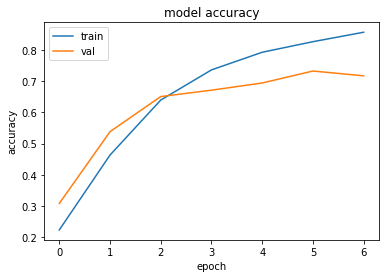

In [40]:
#plotting accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

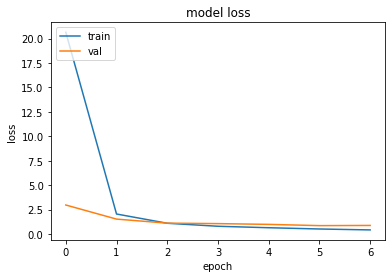

In [41]:
#plotting loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [42]:
# make predictions on the testing set
print("[INFO] evaluating network...")
y_pred = model.predict(testX, batch_size=BS)
print("\t#### RESULTS ####")
#accuracy
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(testY.argmax(1), y_pred.argmax(1)))
print("F1 Score: ",metrics.f1_score(testY.argmax(1), y_pred.argmax(1), average='macro'))

[INFO] evaluating network...
	#### RESULTS ####
Accuracy: 0.7168367346938775
F1 Score:  0.7061658119814753


## Model for entire train data

In [43]:
EP=6#set epochs
BS = 128 #set batchsize

# compile our model
model=build_model()
model.compile(loss="categorical_crossentropy", optimizer='adam',
	metrics=["accuracy"])

In [44]:
# training the model
history = model.fit(
	x=data, y=labels, batch_size=BS,
	epochs=EP)

Epoch 1/6
21/21 [==============================] - 11s 415ms/step - loss: 13.2945 - accuracy: 0.2559
Epoch 2/6
21/21 [==============================] - 8s 371ms/step - loss: 1.9301 - accuracy: 0.5080
Epoch 3/6
21/21 [==============================] - 8s 372ms/step - loss: 1.0532 - accuracy: 0.6655
Epoch 4/6
21/21 [==============================] - 8s 375ms/step - loss: 0.7792 - accuracy: 0.7464
Epoch 5/6
21/21 [==============================] - 8s 381ms/step - loss: 0.6010 - accuracy: 0.7927
Epoch 6/6
21/21 [==============================] - 8s 381ms/step - loss: 0.4715 - accuracy: 0.8456


## Saving the model

In [45]:
# serialize the model to disk
print("[INFO] saving pnemonia detection model...")
model.save("Dog_breed_detect.h5")

[INFO] saving pnemonia detection model...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Testing

In [46]:
file_path='Dog_breed_detect.h5'
from tensorflow.keras.models import load_model
saved_model = load_model(file_path)


In [47]:
def test_img(path): 
  #inputs path of image
  #outputs image class in string and prediction score
  names=['beagle', 'chihuahua', 'doberman', 'french_bulldog', 'golden_retriever',
  'malamute', 'pug', 'saint_bernard', 'scottish_deerhound', 'tibetan_mastiff']
  img_path=path
  
  #Loading the image
  image = load_img(img_path, target_size=(224, 224))

  #converting image to array
  image = img_to_array(image)
  img = np.expand_dims(image, axis = 0)

  #Generating predictions
  pred=model.predict(img)

  #converting predictions in desired format
  category=names[int(pred.argmax(1))]
  score=pred[0][pred.argmax(1)]
  return [category, score[0]]

In [48]:
test_img('/content/img1.jpeg')

['beagle', 0.99683243]

In [49]:
test_img('/content/img2.jpeg')

['golden_retriever', 0.99982905]